In [35]:
import numpy as np
from hurst import random_walk
import pandas as pd

In [127]:
import scienceplots

In [20]:
import matplotlib.pyplot as plt

In [130]:
plt.style.use(['science', 'notebook', 'ieee'])

## Simulated preprocessed data

In [131]:
def generate_corr(n_features):
    
    u = np.random.uniform(-1, 1, (n_features, n_features))
    np.fill_diagonal(u, 1)
    u = u + u.T
    
    return u/2

In [132]:
def generate_walks(T, n_features, corr):
    
    walks = [random_walk(T, np.random.uniform(0.3, 0.7)) for _ in range(n_features)]
    walks = np.array(walks).T
    walks = np.dot(walks[1:, :] - walks[:-1, :], corr)
    
    return np.cumsum(walks, axis=0)

In [133]:
T=200
n_features=10

corr = generate_corr(n_features)
walks = generate_walks(T, n_features, corr)

columns = [f'x_{i}' for i in range(9)]+ ['y']
data =  pd.DataFrame(walks, columns=columns)

## Model Selection

In [135]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import statsmodels.api as sm

class ModelFitter:
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.models = {
            'XGBoost': None,
            'OLS': None,
            'RandomForest': None,
            'Lasso': None,
            'PC Regression': None
        }
        self.results = {}
        self.predictions = {}
        self.target_test = {}

    def fit_models(self):
        X = self.data.drop(self.target, axis=1)
        y = self.data[self.target]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Fit models
        self.models['XGBoost'] = XGBRegressor().fit(X_train, y_train)
        self.models['OLS'] = sm.OLS(y_train, sm.add_constant(X_train)).fit()
        self.models['RandomForest'] = RandomForestRegressor().fit(X_train, y_train)
        self.models['Lasso'] = Lasso().fit(X_train, y_train)
        
        self.y_test = y_test
        
        # For PC Regression
        pca = PCA(n_components=min(X_train.shape))
        X_train_pca = pca.fit_transform(X_train)
        self.models['PC Regression'] = sm.OLS(y_train, sm.add_constant(X_train_pca)).fit()

        # Store results
        for name, model in self.models.items():
            if name in ['OLS', 'PC Regression']:
                self.results[name] = model.llf
            else:
                # Calculate likelihood 
                predictions = model.predict(X_test)
                mse = mean_squared_error(y_test, predictions)
                likelihood = -0.5 * len(y_test) * np.log(2 * np.pi * mse) - 0.5 * len(y_test)
                self.results[name] = likelihood
                self.predictions[name] = predictions
                
    
    def get_results(self):
        return self.results
    
    def retrieve_max_llf_model(self):
        self.best_model = pd.Series(results).idxmax()
        self.best_llf = pd.Series(results).max()
        print(f'Best model is: {self.best_model} with Log-likelihood of: {self.best_llf}')        
        
    def plot_predictions(self):
        
        if not hasattr(self, 'best_model'):
            raise Exception("Model not fitted")
        
        n_models = len(self.predictions.items())
        fig, ax = plt.subplots(nrows=n_models)
        fig.set_size_inches(20, 15)
        
        for _ in range(n_models):
            
            model = list(self.predictions.keys())[_]
            tmp_df = pd.DataFrame({'Predictions': self.predictions[model], 'Realized':self.y_test}).reset_index(drop=True)
            tmp_df.plot(ax=ax[_])
        

In [136]:
fitter = ModelFitter(data, 'y')
fitter.fit_models()
results = fitter.get_results()

In [137]:
fitter.retrieve_max_llf_model()

Best model is: RandomForest with Log-likelihood of: -123.33631771925869


In [138]:
fitter.plot_predictions()

<Axes: >

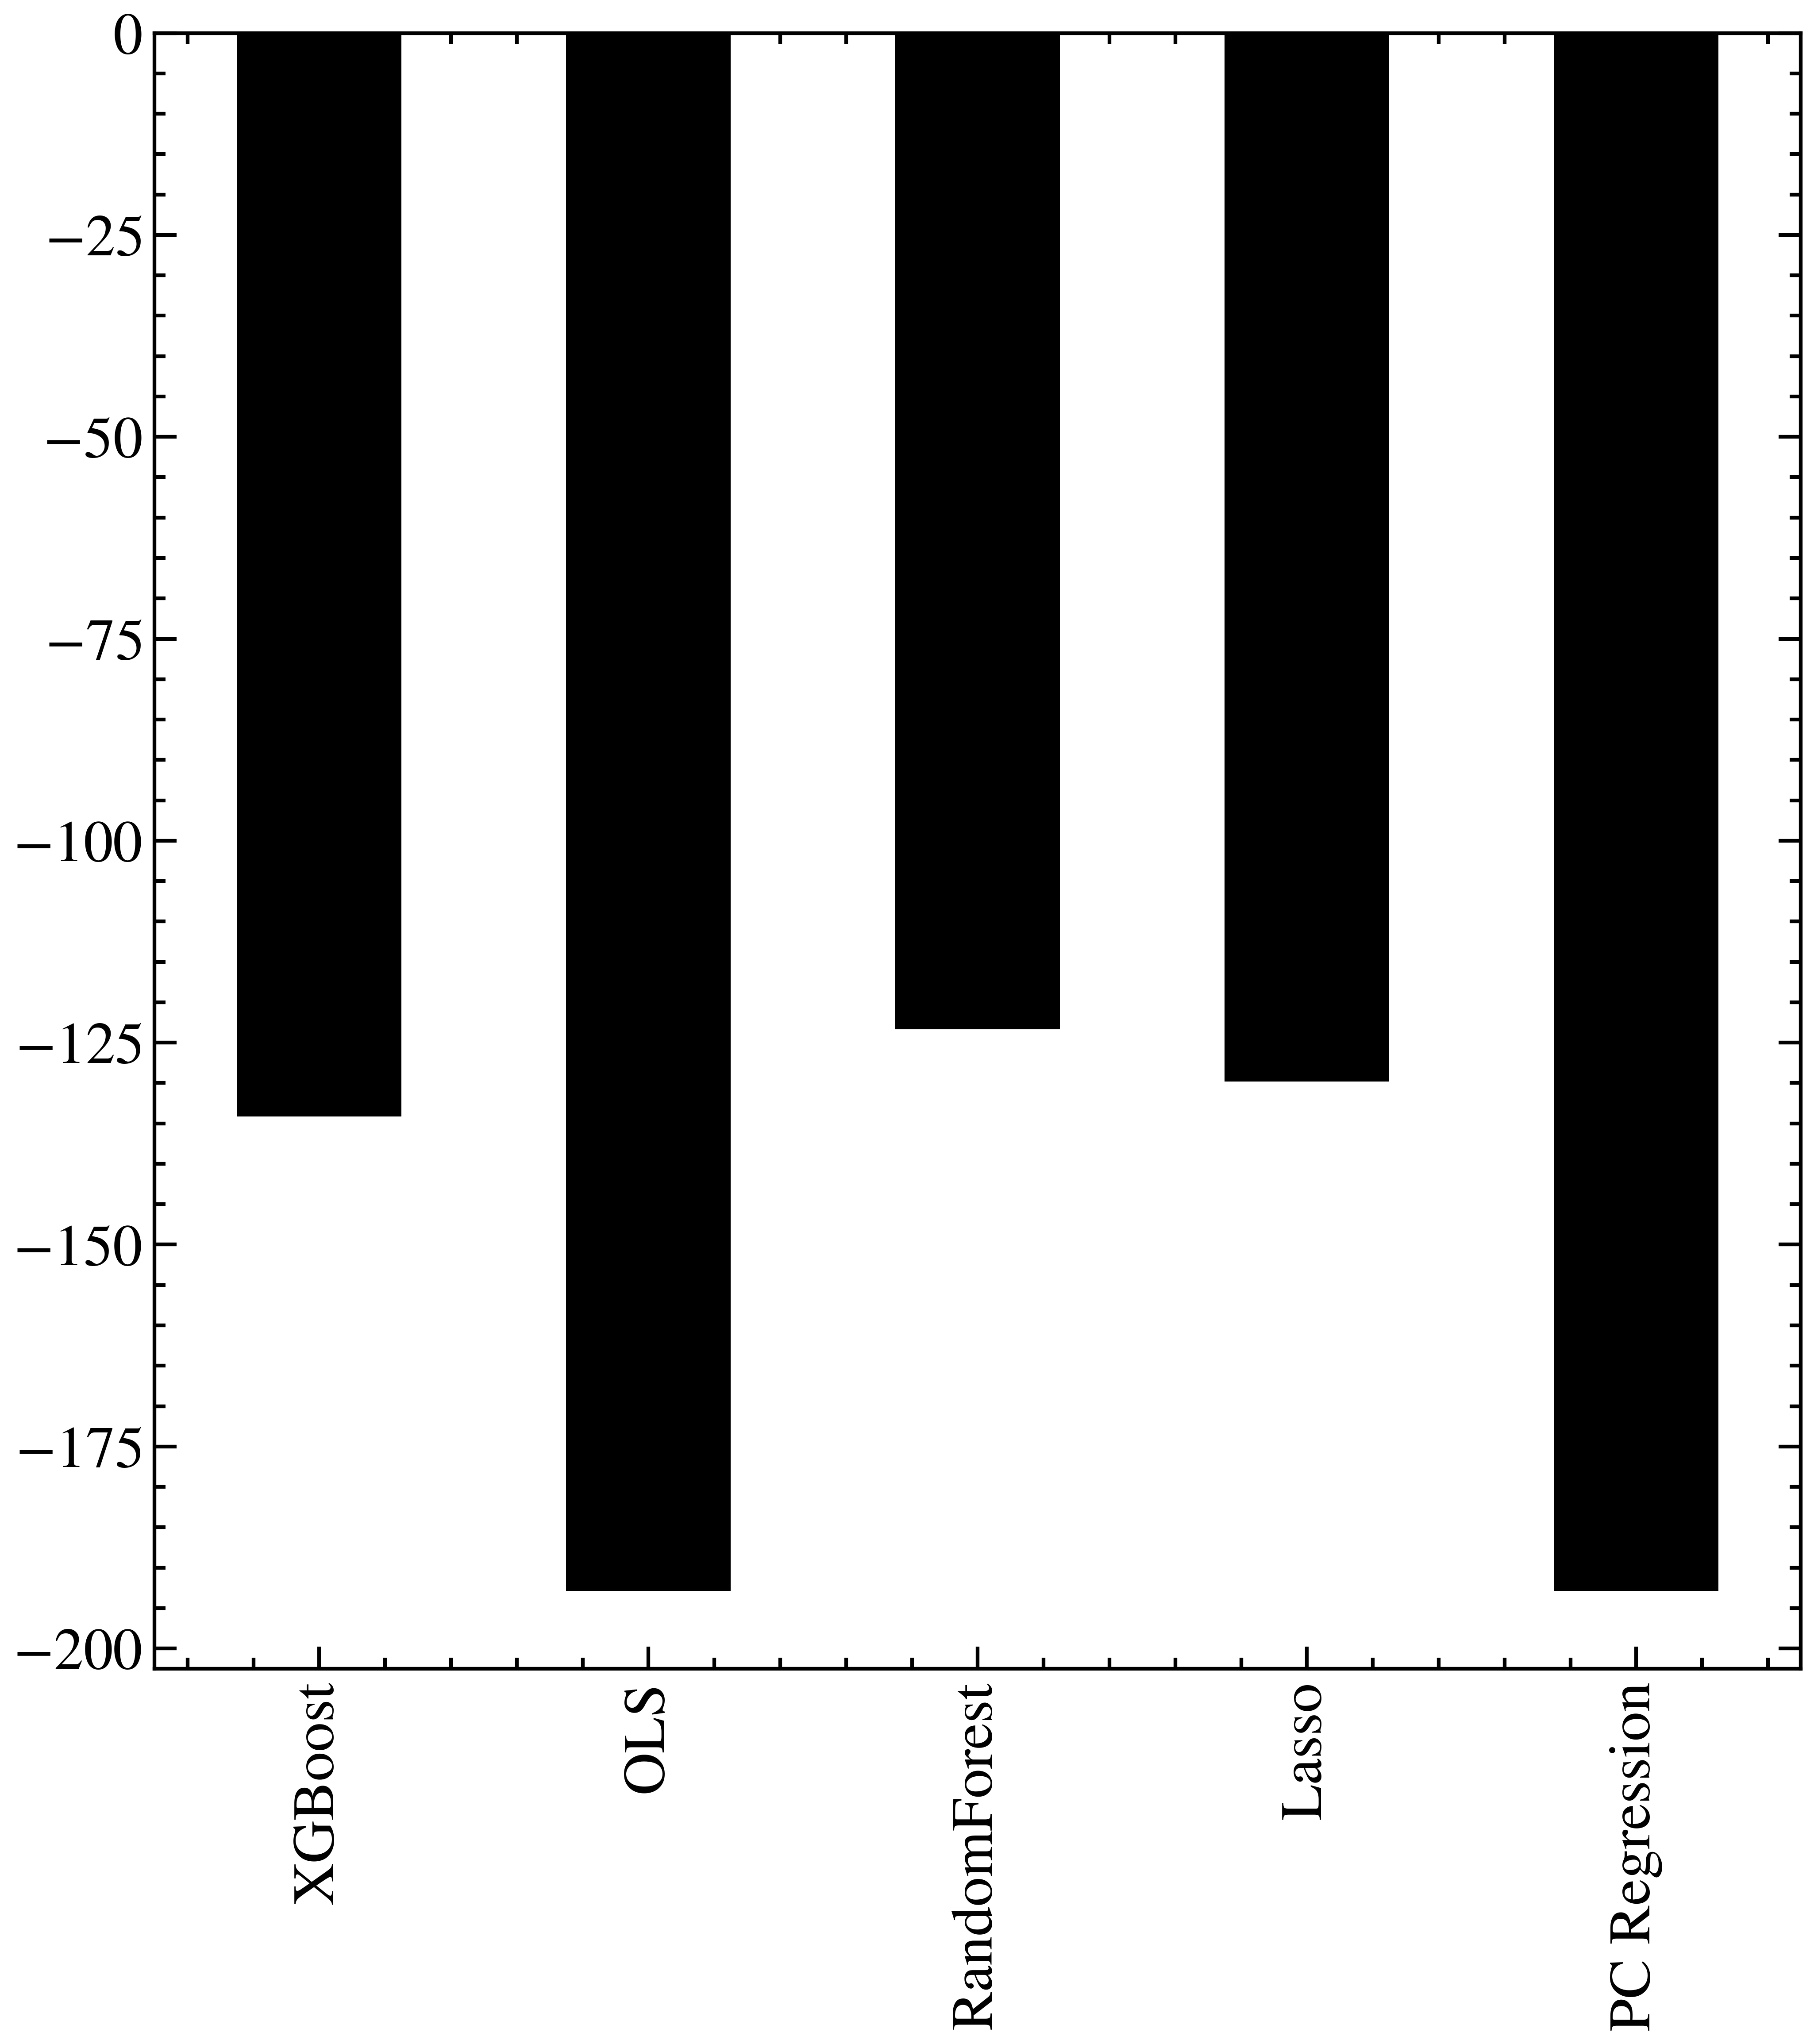

In [140]:
pd.Series(results).plot(kind='bar', figsize=(8, 8))